In [1]:
import sys
import os
sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [3]:
cfg.data.sdoml.sub_directory.eve

'EVE_legacy.zarr"'

In [5]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 4,
    num_workers = 10,
    num_frames  = 2,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2010-01-01',
    end_date   = '2010-12-31',
    dim = False,
    sampling_period = '4days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 64, 32, stride=4)
        self.conv2 = nn.Conv2d(64, 64, 32, stride=4)
        self.conv3 = nn.Conv2d(64, 64, 16, stride=4)
        self.fc1 = nn.Linear(256, 256)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x) # last encoding layer
    
        return x

    
class EncoderMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(4 ,4)
        self.fc1 = nn.Linear(128*128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)

    def forward(self, x):
        x = self.pool(x)       # downsample img
        x = torch.flatten(x,1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
    
        return x
    
    
    
class TimedeltaMLP(nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.fc1 = nn.Linear(encoding_size*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024,512)
        self.fc4 = nn.Linear(512,1)
        

    def forward(self, x):        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x
    
class AssembledModel(nn.Module):
    
    def __init__(self, encoding_size, encoder_class):
        super().__init__()
        self.encoder         = encoder_class()
        self.timedelta_model = TimedeltaMLP(encoding_size)
        
    def forward(self, x1, x2):

        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        
        x = torch.concat([x1, x2], dim=1)
        x = self.timedelta_model(x)
        
        return x

## check embeddings shape

In [7]:
model = AssembledModel(encoding_size=256, encoder_class=Encoder)

In [8]:
im1 = torch.rand((4,1,512,512))
im2 = torch.rand((4,1,512,512))

o1 = model.encoder(im1)
o2 = model.encoder(im2)
o1.shape, o2.shape

(torch.Size([4, 256]), torch.Size([4, 256]))

In [9]:
o = model(im1, im2)
o.shape

torch.Size([4, 1])

## instantiate model (encoder + time delta predictor) 

In [10]:
model = AssembledModel(encoding_size=256, encoder_class=Encoder)
channel_idx = 0

psize = [np.prod(i.shape) for i in model.encoder.parameters()]
print ("encoder parameters        ", sum(psize))

psize = [np.prod(i.shape) for i in model.timedelta_model.parameters()]
print ("timedelta model parameters", sum(psize))

psize = [np.prod(i.shape) for i in model.parameters()]
print ("model total parameters    ", sum(psize))

encoder parameters         5374400
timedelta model parameters 1313281
model total parameters     6687681


## build dadtaloader objects

In [11]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

(3744, 653)

## send models to cuda and init optimizer

In [12]:
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
loss_fn = lambda a,b: torch.mean((a-b)**2 )

## training loop

In [13]:
et = ElapsedTimes()
num_epochs = 100
lossh, lossvalh = [], []
for epoch in range(num_epochs):
    t0 = datetime.now() 

    for step, batch in enumerate(dltrain):
        # extract data from batch
        with et("batch"):
            n = len(batch['image_stack'])
            
            # assumes two timeframes, compute actual time between both timeframes and scales it
            # wrt to the sampling period so that it is in [0,1]
            t = batch['timestamps']
            tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                          for ni in range(n)])\
                                       .reshape(-1,1)\
                                       .cuda()

            image_stack_t0 = batch['image_stack'][:,channel_idx:channel_idx+1,0,:,:].cuda()
            image_stack_t1 = batch['image_stack'][:,channel_idx:channel_idx+1,1,:,:].cuda()

        # run model
        with et("forward"):
            
            tdeltas_pred = model(image_stack_t0, image_stack_t1)

        # compute loss
        with et("loss"):
            loss = loss_fn(tdeltas_pred,tdeltas_truth)

        # backpropage and sigmoidupdate
        with et("backward"):
            loss.backward()
            optimizer.step()
            
        with et("validation"):
            """
            # measure on val every 10 steps
            if step%10 == 0:
                try:
                    val_batch = next(val_iter)        
                except Exception as e:
                    val_iter = iter(dlval)                
                    val_batch = next(val_iter)        

                xval = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
                fval = batch['dim_factor'].type(torch.float).cuda()
                with torch.no_grad():
                    oval = model(x)
                    lossval = loss_fn(f,o)

                    lossvaln = lossval.detach().cpu().numpy()
            """
            lossvaln = 0.
        with et("logging"):
            # cosmetics
            lossn = loss.detach().cpu().numpy()
            lossh.append(lossn)

            lossvalh.append(lossvaln)


            psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
            lossm = np.mean(lossh[-100:])
            lossvalm = np.mean(lossvalh[-100:])
            epoch_time = (datetime.now() - t0).seconds
            print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

    print()

KeyboardInterrupt: 

In [15]:
et

{'batch': 0.6398890018463135, 'forward': 0.7275786399841309, 'loss': 0.1072835922241211, 'backward': 0.8185610771179199, 'validation': 0.0002532005310058594, 'logging': 6.649980068206787}

In [16]:
sum(list(et.elapsed_times.values()))

8.943545579910278

In [17]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)

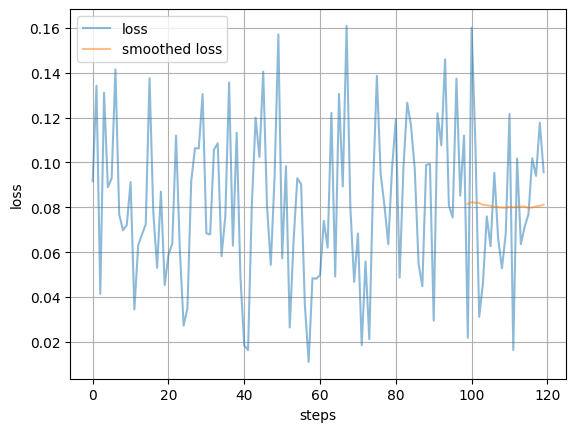

In [19]:
ploth(lossh)
#plt.ylim(.2,.4)

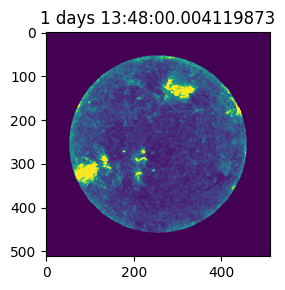

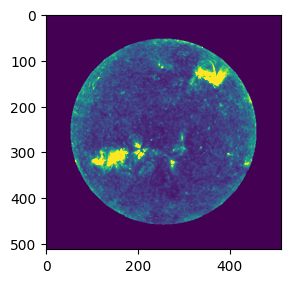

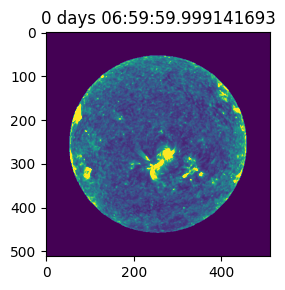

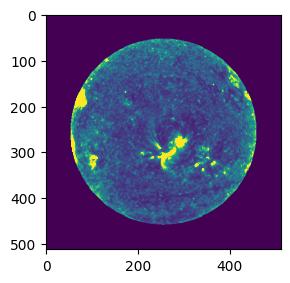

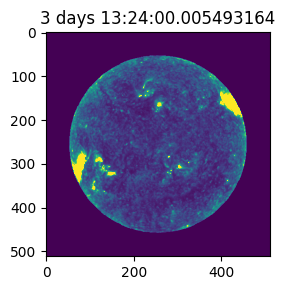

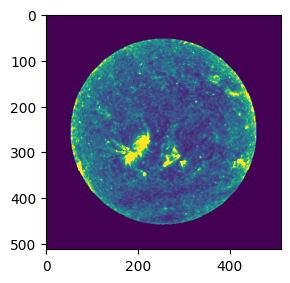

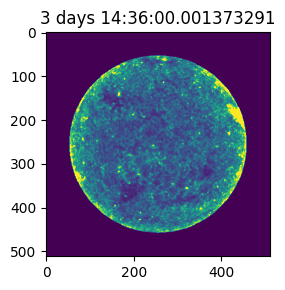

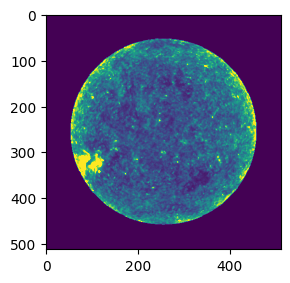

In [39]:
batch_element = 0
for batch_element in range(len(batch['image_stack'])):
    x0 = image_stack_t0[batch_element]
    x1 = image_stack_t1[batch_element]

    for ax,i in subplots(len(x0)):
        if i==0:
            s = str(tdeltas_truth[batch_element,0].cpu().numpy() * pd.Timedelta(data_module.sampling_period))
            plt.title(s)

        xi = x0[i].cpu().numpy()
        a,b = np.percentile(xi, [0,99])
        plt.imshow(xi, vmin=a, vmax=b)

    for ax,i in subplots(len(x1)):
        xi = x1[i].cpu().numpy()
        a,b = np.percentile(xi, [0,99])
        plt.imshow(xi, vmin=a, vmax=b)

